# Continuous Control

---
This notebook is based on the code of the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.
We will use the same Unity ML-Agents environment.<br>
In this notebook, we will train 20 parallels agents with DDPG

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_one/Reacher_Windows_x86_64/Reacher.exe')

#env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
brain_name 

'ReacherBrain'

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Training

Now, we will train our own PPO agent to solve the environment.<br>  When training the environment, we set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
from model import Actor_PPO, Critic_PPO

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque
import copy

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# source : https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/model.py
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1.0 / np.sqrt(fan_in)
    return (-lim, lim)

In [133]:

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.98            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
NUM_EPOCHS = 20
SEED=47
LAMBDA=0.5

class Agent():
    
    def __init__(self, state_size, action_size, random_seed, epsilon=0.3, entropy_coef=0.001):
        
        
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = BATCH_SIZE
        self.num_epochs = NUM_EPOCHS
        self.seed = random.seed(random_seed)
        self.epsilon = epsilon
        self.entropy_coef = entropy_coef
        
        self.actor_local = Actor_PPO(state_size=state_size, action_size=action_size, size1=256, seed=SEED).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY)
            
        self.critic_local = Critic_PPO(state_size=state_size,size1=256,seed=SEED).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
            
        self.noise = OUNoise(action_size, random_seed)
        
        self.memory = Memory()
        self.train=True
        self.actor_loss_history=deque(maxlen=1000)
        self.critic_loss_history=deque(maxlen=1000)
            
    def step(self, states, actions, rewards, next_states, dones, distributions, log_probs):
        states = torch.tensor(states, dtype=torch.float, device=device)
        
        if self.train:
            self.actor_local.eval()
            with torch.no_grad():
                values = self.critic_local(states)
                self.memory.add_steps(states, actions, rewards, dones, values, log_probs)# next_states, 
            self.actor_local.train()
        
    
    def act(self, states, add_noise=False):
        states =torch.tensor(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions, distributions = self.actor_local(states)
            actions = actions.cpu().numpy()
        
            if add_noise:
                actions += self.noise.sample()
            log_probs = distributions.log_prob(torch.FloatTensor(actions).to(device))
            log_probs = torch.sum(log_probs, axis=-1, keepdim=True)
        self.actor_local.train()
        return np.clip(actions, -1, 1), distributions, log_probs
        
    def reset(self):
        self.noise.reset()
        
    def learn(self,last_states, gamma):
        """Update policy and value parameters using given sequences of experience.
        where:
            self.actor (state) -> action, distribution
            self.critic (state) -> State_Value

        Params
        ======
            last_states (numpy.array): last "next_states" of the sequence  
            gamma (float): discount factor
        """
        last_values = self.critic_local(torch.FloatTensor(last_states).to(device)).cpu().detach().numpy()
        
        
        returns = self.get_gae(self.memory.rewards, self.memory.values+[last_values], self.memory.dones)
        self.returns = returns
        actor_losses, critic_losses = [], []
        
        states = torch.FloatTensor(self.memory.states).to(device)
        actions = torch.FloatTensor(self.memory.actions).to(device)
        log_probs = torch.FloatTensor(np.array(self.memory.log_probs)).to(device)
        values = torch.FloatTensor(self.memory.values).to(device).view(-1,1)
        returns = torch.FloatTensor(returns).to(device).view(-1,1)#.squeeze()
        assert  returns.shape == values.shape
        advantages = returns - values#[:-1]
        self.advantages = advantages
        
        for state, action, return_, old_log_prob, old_value, advantage in trajectories_data_generator(
            states=states,
            actions=actions,
            returns=returns,
            log_probs=log_probs,
            values=values,
            advantages=advantages,
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            ):
            
            
            _, new_dist = self.actor_local(state)
            cur_log_prob = new_dist.log_prob(action)
            cur_log_prob=torch.sum(cur_log_prob, dim=-1, keepdim=False)
            ratio = torch.exp(cur_log_prob - old_log_prob.detach())

            
            assert advantage.shape == old_value.shape
            # compute actor loss
            entropy = new_dist.entropy().mean(axis=-1, keepdim=False)
            
            

            
            loss =  advantage.detach() * ratio
            clipped_loss = (
                torch.clamp(ratio, 1. - self.epsilon, 1. + self.epsilon)
                 * advantage.detach()
                )
            actor_loss = (
                -torch.min(loss, clipped_loss)
                - entropy * self.entropy_coef)
            
            actor_loss = actor_loss.mean()
            
            
            #compute critic loss
            cur_value = self.critic_local(state.view(-1,self.state_size))
            critic_loss = F.mse_loss(return_, cur_value)
        
        
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 5)
            self.critic_optimizer.step()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 5)
            self.actor_optimizer.step()
            actor_losses.append(actor_loss.cpu().detach().numpy())
            critic_losses.append(critic_loss.cpu().detach().numpy())
            
        
        self.actor_loss_history.append(np.mean(actor_losses))
        self.critic_loss_history.append(np.mean(critic_losses))
        

        
    def get_gae(self, rewards, values, dones):
        """Computes a list of estimators of the advantage function at each timestep of the episode
        
        Params
        ======
             rewards: list of rewards
             values: list of value function values
             dones: list of terminal state flags
             
        Return
        ======
            discounted sum of rewards
        """
        gae=0
        returns=[]
        for i in reversed(range(len(rewards))):
            delta = rewards[i]+GAMMA*values[i+1]*(1-dones[i])-values[i]
            gae = delta+GAMMA*LAMBDA*(1-dones[i])*gae
            returns.insert(0, gae+values[i])
        return returns
               
        
        
class OUNoise:
    """Ornstein-Uhlenbeck process"""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.05):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        
    def reset(self):
        """Update internal state and return it as a noise sample."""
        self.state = copy.copy(self.mu)
    def sample(self):
        x=self.state
        dx = self.theta*(self.mu - x)+self.sigma* np.random.normal(loc=0, scale=1, size=len(x))#np.random.normal(loc=0, scale=1, size=len(x)))#np.array([random.random() for i in range(len(x))])
        self.state = x+dx
        return self.state
            

class Memory:
    """Storing the memory of the trajectory (s, a, r ...)."""
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []
    def add_steps(self, states, actions, rewards, dones, values, log_probs):
        
        self.states.append(states.cpu().detach().numpy())
        self.actions.append(actions)
        self.rewards.append(np.array(rewards)[:,np.newaxis])
        self.dones.append(np.array(dones)[:,np.newaxis])
        self.log_probs.append(np.array(log_probs.sum(axis=-1).cpu().detach()))
        
        self.values.append(values.cpu().detach().numpy())
        
        

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []

In [136]:
#sources : https://github.com/mandrakedrink/PPO-pytorch/blob/master/ppo/utils.py
def trajectories_data_generator(
    states: torch.Tensor,
    actions: torch.Tensor,
    returns: torch.Tensor,
    log_probs: torch.Tensor,
    values: torch.Tensor,
    advantages: torch.Tensor,
    batch_size,
    num_epochs,
    ):
    """data-generator."""
    data_len = states.size(0)
    for _ in range(num_epochs):
        for _ in range(data_len // batch_size):
            ids = np.random.choice(data_len, batch_size, replace=False)
            yield states[ids], actions[ids], returns[ids], log_probs[ids], values[ids], advantages[ids]

In [140]:
agent = Agent(state_size, action_size, SEED)

### Training loop :

Episode 1	Average Score: 0.71	Score: 0.71	LossActor: -0.00686376 	LossCritic : 0.00007253(tensor([[ 0.2936,  0.0897, -0.3881,  0.0096]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.9932, 0.9010, 1.1222, 0.6513]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 2	Average Score: 0.35	Score: 0.00	LossActor: -0.00586851 	LossCritic : 0.00003758(tensor([[-0.1073, -0.1398, -0.1207, -0.1706]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.9803, 0.9973, 0.9491, 0.9685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 3	Average Score: 0.33	Score: 0.28	LossActor: -0.00563367 	LossCritic : 0.00003559(tensor([[ 0.0949,  0.1733,  0.0082, -0.1512]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.9720, 0.8996, 0.7761, 0.6295]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 4	Average Score: 0.25	Score: 0.00	LossActor: -0.00526972 	LossCritic : 0.00002742(tensor([[-0.0078,  0.0530,  0.1074, -0.0363]], device='cuda:0',
       gr

Episode 31	Average Score: 0.67	Score: 0.19	LossActor: 0.00156031 	LossCritic : 0.00007624(tensor([[-0.2817, -0.2646, -0.3189, -0.2095]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.4833, 0.4036, 0.4039, 0.3888]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 32	Average Score: 0.67	Score: 0.80	LossActor: 0.00146664 	LossCritic : 0.00007684(tensor([[-0.2628,  0.4835, -0.3288,  0.6671]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3904, 0.3773, 0.3755, 0.3721]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 33	Average Score: 0.66	Score: 0.28	LossActor: 0.00147947 	LossCritic : 0.00007593(tensor([[-0.6274, -0.9825, -0.9076,  0.8191]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3961, 0.3680, 0.3692, 0.3680]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 34	Average Score: 0.67	Score: 0.80	LossActor: 0.00148100 	LossCritic : 0.00007635(tensor([[ 0.3397,  0.5145, -0.5362,  0.5862]], device='cuda:0',
       gr

Episode 61	Average Score: 0.89	Score: 2.32	LossActor: 0.00021717 	LossCritic : 0.00009418(tensor([[ 0.1483,  0.2245,  0.3162, -0.3963]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3721, 0.3723, 0.3723, 0.3696]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 62	Average Score: 0.92	Score: 2.51	LossActor: 0.00016973 	LossCritic : 0.00009591(tensor([[-0.5482,  0.2808, -0.0787, -0.1093]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3866, 0.3781, 0.3796, 0.3807]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 63	Average Score: 0.91	Score: 0.64	LossActor: 0.00018398 	LossCritic : 0.00009592(tensor([[-0.5006,  0.2761,  0.0100,  0.0182]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3862, 0.3860, 0.3853, 0.3865]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 64	Average Score: 0.93	Score: 2.20	LossActor: 0.00014932 	LossCritic : 0.00009771(tensor([[ 0.1227, -0.0197,  0.2960, -0.4247]], device='cuda:0',
       gr

Episode 91	Average Score: 1.16	Score: 4.01	LossActor: -0.00012721 	LossCritic : 0.00012048(tensor([[-0.2011,  0.4095, -0.2595, -0.1025]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3729, 0.3710, 0.3706, 0.3704]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 92	Average Score: 1.16	Score: 1.58	LossActor: -0.00013728 	LossCritic : 0.00012134(tensor([[-0.4646,  0.4666, -0.4981, -0.3333]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3688, 0.3691, 0.3684, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 93	Average Score: 1.17	Score: 2.20	LossActor: -0.00015183 	LossCritic : 0.00012218(tensor([[-0.0876,  0.1309, -0.2389, -0.2888]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3766, 0.3725, 0.3729, 0.3728]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 94	Average Score: 1.17	Score: 1.37	LossActor: -0.00012709 	LossCritic : 0.00012226(tensor([[ 0.4113, -0.2905,  0.1230, -0.4902]], device='cuda:0',
     

Episode 121	Average Score: 1.69	Score: 2.71	LossActor: -0.00040945 	LossCritic : 0.00015162(tensor([[-0.3011, -0.2395, -0.4539, -0.0110]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3698, 0.3692, 0.3686, 0.3683]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 122	Average Score: 1.72	Score: 3.17	LossActor: -0.00042068 	LossCritic : 0.00015263(tensor([[-0.1297, -0.2425,  0.1960, -0.0512]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3762, 0.3812, 0.3731, 0.3715]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 123	Average Score: 1.72	Score: 1.57	LossActor: -0.00039863 	LossCritic : 0.00015288(tensor([[-0.1869, -0.0444,  0.2321, -0.0194]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3684, 0.3683, 0.3684, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 124	Average Score: 1.75	Score: 3.82	LossActor: -0.00041509 	LossCritic : 0.00015454(tensor([[ 0.1718,  0.2143,  0.2301, -0.2043]], device='cuda:0',
 

Episode 151	Average Score: 2.69	Score: 1.38	LossActor: -0.00058499 	LossCritic : 0.00020693(tensor([[-0.2218, -0.7578, -0.6796, -0.4290]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3688, 0.3681, 0.3681, 0.3680]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 152	Average Score: 2.76	Score: 7.49	LossActor: -0.00062159 	LossCritic : 0.00020956(tensor([[-0.3810, -0.5185, -0.1223, -0.4111]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3685, 0.3682, 0.3682, 0.3681]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 153	Average Score: 2.79	Score: 3.39	LossActor: -0.00039994 	LossCritic : 0.00021198(tensor([[-0.3100, -0.3493,  0.0256, -0.1466]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3729, 0.3711, 0.3715, 0.3705]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 154	Average Score: 2.83	Score: 5.27	LossActor: -0.00037435 	LossCritic : 0.00021519(tensor([[-0.4750,  0.0061,  0.0286,  0.2885]], device='cuda:0',
 

Episode 181	Average Score: 3.36	Score: 2.91	LossActor: 0.00012832 	LossCritic : 0.00024954(tensor([[ 0.4412, -0.1169,  0.6454,  0.0069]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3684, 0.3681, 0.3681, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 182	Average Score: 3.39	Score: 4.66	LossActor: 0.00013104 	LossCritic : 0.00025085(tensor([[ 0.0479,  0.3016, -0.1054, -0.3949]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3684, 0.3682, 0.3683, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 183	Average Score: 3.41	Score: 4.03	LossActor: 0.00013510 	LossCritic : 0.00025218(tensor([[-0.1516,  0.1116, -0.5566, -0.0914]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3711, 0.3686, 0.3689, 0.3688]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 184	Average Score: 3.43	Score: 3.43	LossActor: 0.00014385 	LossCritic : 0.00025239(tensor([[ 0.3302, -0.3231,  0.0671,  0.2835]], device='cuda:0',
     

Episode 211	Average Score: 3.96	Score: 6.14	LossActor: 0.00026073 	LossCritic : 0.00028550(tensor([[ 0.1023,  0.0267, -0.3786,  0.1340]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3700, 0.3690, 0.3692, 0.3691]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 212	Average Score: 3.99	Score: 5.01	LossActor: 0.00026284 	LossCritic : 0.00028779(tensor([[ 0.3339,  0.2941,  0.5185, -0.0241]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3689, 0.3686, 0.3687, 0.3687]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 213	Average Score: 4.00	Score: 3.75	LossActor: 0.00026826 	LossCritic : 0.00028973(tensor([[-0.3000,  0.0982,  0.2144,  0.3867]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3694, 0.3690, 0.3695, 0.3696]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 214	Average Score: 4.04	Score: 7.56	LossActor: 0.00024045 	LossCritic : 0.00029190(tensor([[-0.0353,  0.0978, -0.2368, -0.5419]], device='cuda:0',
     

Episode 241	Average Score: 4.55	Score: 5.96	LossActor: 0.00040637 	LossCritic : 0.00033842(tensor([[-0.1122,  0.0560,  0.0147,  0.2891]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3746, 0.3729, 0.3729, 0.3734]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 242	Average Score: 4.60	Score: 9.76	LossActor: 0.00038891 	LossCritic : 0.00034066(tensor([[ 0.2576,  0.3966, -0.1266,  0.6129]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3696, 0.3692, 0.3690, 0.3696]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 243	Average Score: 4.60	Score: 5.81	LossActor: 0.00038518 	LossCritic : 0.00034171(tensor([[ 0.2988, -0.0719,  0.3960, -0.3695]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3682, 0.3682, 0.3681, 0.3683]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 244	Average Score: 4.61	Score: 8.78	LossActor: 0.00036493 	LossCritic : 0.00034367(tensor([[0.1605, 0.0568, 0.1708, 0.3679]], device='cuda:0',
       gr

Episode 271	Average Score: 5.22	Score: 3.30	LossActor: 0.00057538 	LossCritic : 0.00039244(tensor([[ 0.1560, -0.1645,  0.3213,  0.2687]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3682, 0.3682, 0.3681, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 272	Average Score: 5.26	Score: 7.47	LossActor: 0.00056828 	LossCritic : 0.00039409(tensor([[ 0.0971,  0.0676,  0.2729, -0.3695]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3686, 0.3687, 0.3684, 0.3688]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 273	Average Score: 5.32	Score: 9.96	LossActor: 0.00053425 	LossCritic : 0.00039583(tensor([[ 0.2581,  0.4609,  0.3510, -0.1065]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3684, 0.3688, 0.3683, 0.3688]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 274	Average Score: 5.30	Score: 3.84	LossActor: 0.00055483 	LossCritic : 0.00039609(tensor([[-0.2392,  0.0858, -0.1849,  0.1997]], device='cuda:0',
     

Episode 301	Average Score: 6.80	Score: 18.02	LossActor: 0.00018254 	LossCritic : 0.00044834(tensor([[-0.3831,  0.1161, -0.4556,  0.2056]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3679, 0.3679, 0.3679, 0.3679]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 302	Average Score: 6.83	Score: 7.24	LossActor: 0.00020553 	LossCritic : 0.00045241(tensor([[ 0.3603, -0.1169, -0.0282, -0.0761]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3685, 0.3689, 0.3685, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 303	Average Score: 6.87	Score: 4.08	LossActor: 0.00024881 	LossCritic : 0.00045532(tensor([[-0.1943,  0.1080,  0.1948,  0.3849]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3682, 0.3684, 0.3682, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 304	Average Score: 7.04	Score: 18.16	LossActor: 0.00019942 	LossCritic : 0.00045779(tensor([[-0.3243,  0.1372, -0.0672,  0.2054]], device='cuda:0',
   

Episode 331	Average Score: 10.15	Score: 22.77	LossActor: -0.00038968 	LossCritic : 0.00053621(tensor([[-0.2312,  0.1417, -0.2876,  0.3129]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3681, 0.3680, 0.3681]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 332	Average Score: 10.43	Score: 29.90	LossActor: -0.00046701 	LossCritic : 0.00053801(tensor([[-0.1989, -0.2532, -0.1601, -0.1367]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3691, 0.3688, 0.3685, 0.3688]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 333	Average Score: 10.45	Score: 3.05	LossActor: -0.00039457 	LossCritic : 0.00054164(tensor([[-0.1173, -0.0899, -0.3443,  0.4556]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3702, 0.3700, 0.3692, 0.3697]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 334	Average Score: 10.56	Score: 17.19	LossActor: -0.00040356 	LossCritic : 0.00054498(tensor([[-0.0960,  0.1182,  0.4411,  0.1252]], device='cud

Episode 361	Average Score: 13.80	Score: 36.43	LossActor: -0.00053662 	LossCritic : 0.00062326(tensor([[ 0.5229,  0.2440, -0.5620,  0.2274]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3680, 0.3680, 0.3680, 0.3680]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 362	Average Score: 14.13	Score: 36.59	LossActor: -0.00062166 	LossCritic : 0.00062411(tensor([[0.4708, 0.3372, 0.1004, 0.0831]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3681, 0.3680, 0.3681]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 363	Average Score: 14.34	Score: 24.04	LossActor: -0.00064120 	LossCritic : 0.00062718(tensor([[0.4379, 0.1414, 0.0554, 0.4201]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3681, 0.3680, 0.3681]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 364	Average Score: 14.38	Score: 11.29	LossActor: -0.00057519 	LossCritic : 0.00063049(tensor([[0.1382, 0.1600, 0.2098, 0.5153]], device='cuda:0',
     

Episode 390	Average Score: 20.97	Score: 37.05	LossActor: -0.00136780 	LossCritic : 0.00066710(tensor([[0.4946, 0.1237, 0.1261, 0.0259]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3682, 0.3681, 0.3681, 0.3681]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 391	Average Score: 21.33	Score: 38.77	LossActor: -0.00140270 	LossCritic : 0.00066629(tensor([[-0.1752, -0.2191, -0.1349, -0.0547]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3687, 0.3685, 0.3684, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 392	Average Score: 21.47	Score: 20.08	LossActor: -0.00134745 	LossCritic : 0.00066911(tensor([[ 0.1157,  0.2866, -0.4136,  0.3997]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3680, 0.3680, 0.3681]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 393	Average Score: 21.54	Score: 26.06	LossActor: -0.00132827 	LossCritic : 0.00067157(tensor([[-0.2093,  0.1522,  0.2309, -0.5235]], device='cuda:0

Episode 419	Average Score: 26.37	Score: 33.95	LossActor: -0.00139851 	LossCritic : 0.00068679(tensor([[0.3864, 0.1292, 0.4317, 0.4931]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3681, 0.3680, 0.3680]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 420	Average Score: 26.40	Score: 17.75	LossActor: -0.00132756 	LossCritic : 0.00068838(tensor([[ 0.1332, -0.0946,  0.5288,  0.0011]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3681, 0.3680, 0.3680]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 421	Average Score: 26.64	Score: 33.85	LossActor: -0.00133742 	LossCritic : 0.00068843(tensor([[ 0.0871, -0.2177, -0.3703, -0.3839]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3690, 0.3688, 0.3686, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 422	Average Score: 26.85	Score: 38.81	LossActor: -0.00136375 	LossCritic : 0.00068758(tensor([[ 0.5231, -0.1415,  0.3041,  0.0405]], device='cuda:0

Episode 448	Average Score: 31.43	Score: 26.40	LossActor: -0.00141921 	LossCritic : 0.00068520(tensor([[-0.5829, -0.0535,  0.6554,  0.4056]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3680, 0.3680, 0.3680, 0.3680]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 449	Average Score: 31.62	Score: 37.54	LossActor: -0.00143784 	LossCritic : 0.00068450(tensor([[-0.1349, -0.1976, -0.4284, -0.2695]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3694, 0.3691, 0.3689, 0.3692]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 450	Average Score: 31.78	Score: 39.05	LossActor: -0.00145711 	LossCritic : 0.00068337(tensor([[ 0.6017, -0.0428,  0.4883, -0.0096]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3683, 0.3682, 0.3682, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 451	Average Score: 31.86	Score: 34.69	LossActor: -0.00145393 	LossCritic : 0.00068340(tensor([[-0.1071, -0.1747, -0.3849,  0.4178]], device='cu

Episode 477	Average Score: 33.64	Score: 39.33	LossActor: -0.00135901 	LossCritic : 0.00067834(tensor([[ 0.0019,  0.0801, -0.0217,  0.4736]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3685, 0.3688, 0.3682, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 478	Average Score: 33.67	Score: 37.78	LossActor: -0.00135985 	LossCritic : 0.00067750(tensor([[0.3223, 0.0270, 0.5270, 0.7298]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3686, 0.3689, 0.3682, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 479	Average Score: 33.66	Score: 36.89	LossActor: -0.00136699 	LossCritic : 0.00067673(tensor([[-0.1434, -0.5938, -0.1068,  0.0094]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3696, 0.3701, 0.3690, 0.3695]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 480	Average Score: 33.68	Score: 27.60	LossActor: -0.00131507 	LossCritic : 0.00067738(tensor([[-0.2477, -0.2313,  0.0952,  0.1459]], device='cuda:0

Episode 506	Average Score: 32.37	Score: 18.71	LossActor: -0.00054012 	LossCritic : 0.00069681(tensor([[ 0.0401,  0.5715, -0.3518,  0.0662]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3686, 0.3689, 0.3686, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 507	Average Score: 32.14	Score: 13.77	LossActor: -0.00046475 	LossCritic : 0.00069884(tensor([[-0.1864,  0.3501,  0.8280,  0.2079]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3682, 0.3682, 0.3681, 0.3681]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 508	Average Score: 32.20	Score: 29.59	LossActor: -0.00045225 	LossCritic : 0.00069908(tensor([[ 0.1730,  0.1742,  0.0722, -0.6703]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3686, 0.3686, 0.3686, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 509	Average Score: 32.13	Score: 26.33	LossActor: -0.00044144 	LossCritic : 0.00069944(tensor([[-0.0138,  0.1621, -0.1788,  0.1588]], device='cu

Episode 535	Average Score: 31.70	Score: 34.01	LossActor: -0.00048117 	LossCritic : 0.00069846(tensor([[0.3412, 0.3664, 0.4495, 0.3145]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3682, 0.3683, 0.3682, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 536	Average Score: 31.68	Score: 34.82	LossActor: -0.00050680 	LossCritic : 0.00069865(tensor([[ 0.1565, -0.1771,  0.1686, -0.3978]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3683, 0.3683, 0.3682, 0.3683]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 537	Average Score: 31.69	Score: 38.91	LossActor: -0.00053213 	LossCritic : 0.00069810(tensor([[-0.1460,  0.1303,  0.0040,  0.0392]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3685, 0.3686, 0.3684, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 538	Average Score: 31.66	Score: 31.63	LossActor: -0.00052863 	LossCritic : 0.00069833(tensor([[ 0.1063, -0.0023, -0.6187, -0.4346]], device='cuda:0

Episode 565	Average Score: 30.44	Score: 25.79	LossActor: -0.00005396 	LossCritic : 0.00071700(tensor([[-0.5275, -0.0799,  0.2081,  0.6028]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3683, 0.3681, 0.3683]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 566	Average Score: 30.41	Score: 35.40	LossActor: -0.00007614 	LossCritic : 0.00071707(tensor([[ 0.2884, -0.5176, -0.2368, -0.3844]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3683, 0.3684, 0.3683, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 567	Average Score: 30.38	Score: 35.67	LossActor: -0.00010215 	LossCritic : 0.00071734(tensor([[-0.1654,  0.2977,  0.1513,  0.3512]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3682, 0.3687, 0.3683, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 568	Average Score: 30.16	Score: 12.55	LossActor: -0.00002529 	LossCritic : 0.00071913(tensor([[ 0.0265, -0.2424,  0.6168,  0.0750]], device='cu

Episode 594	Average Score: 30.07	Score: 27.85	LossActor: 0.00004159 	LossCritic : 0.00072793(tensor([[ 0.1301, -0.5363,  0.4267, -0.3283]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3683, 0.3682, 0.3682, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 595	Average Score: 30.17	Score: 19.43	LossActor: 0.00006506 	LossCritic : 0.00072903(tensor([[-0.3000, -0.2183, -0.0152,  0.3118]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3684, 0.3684, 0.3683, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 596	Average Score: 30.01	Score: 12.01	LossActor: 0.00086914 	LossCritic : 0.00073093(tensor([[ 0.4073, -0.3056, -0.4348,  0.1657]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3681, 0.3681, 0.3680]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 597	Average Score: 29.71	Score: 2.76	LossActor: 0.00098068 	LossCritic : 0.00073379(tensor([[ 0.9199,  0.2542, -0.7726, -0.8597]], device='cuda:0'

Episode 623	Average Score: 28.92	Score: 31.18	LossActor: 0.00112992 	LossCritic : 0.00073818(tensor([[-0.3992,  0.2809, -0.3085,  0.1059]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3686, 0.3686, 0.3685, 0.3684]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 624	Average Score: 28.88	Score: 34.73	LossActor: 0.00113022 	LossCritic : 0.00073803(tensor([[-0.1874, -0.3230, -0.3485, -0.4454]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3687, 0.3684, 0.3684, 0.3684]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 625	Average Score: 28.95	Score: 33.20	LossActor: 0.00111729 	LossCritic : 0.00073800(tensor([[-0.2755,  0.5575, -0.0937, -0.1999]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3685, 0.3686, 0.3684, 0.3683]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 626	Average Score: 28.92	Score: 35.27	LossActor: 0.00110301 	LossCritic : 0.00073800(tensor([[ 0.0336,  0.2949, -0.3999, -0.5076]], device='cuda:0

Episode 653	Average Score: 29.33	Score: 21.81	LossActor: 0.00097188 	LossCritic : 0.00072802(tensor([[-0.1748,  0.2582,  0.3248,  0.2726]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3697, 0.3691, 0.3689, 0.3689]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 654	Average Score: 29.31	Score: 33.81	LossActor: 0.00097090 	LossCritic : 0.00072784(tensor([[-0.6583, -0.2022, -0.0020,  0.0719]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3693, 0.3687, 0.3685, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 655	Average Score: 29.41	Score: 35.72	LossActor: 0.00096896 	LossCritic : 0.00072740(tensor([[-0.3984, -0.1004, -0.5216,  0.2685]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3696, 0.3688, 0.3686, 0.3687]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 656	Average Score: 29.50	Score: 35.20	LossActor: 0.00095958 	LossCritic : 0.00072705(tensor([[-0.3607,  0.2415, -0.4371,  0.0448]], device='cuda:0

Episode 683	Average Score: 31.09	Score: 15.95	LossActor: 0.00122594 	LossCritic : 0.00072349(tensor([[0.1642, 0.0138, 0.2925, 0.8059]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3687, 0.3686, 0.3692, 0.3684]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 684	Average Score: 31.14	Score: 34.73	LossActor: 0.00121788 	LossCritic : 0.00072367(tensor([[-0.3498, -0.4975, -0.4082,  0.5785]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3687, 0.3686, 0.3694, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 685	Average Score: 31.17	Score: 33.91	LossActor: 0.00120778 	LossCritic : 0.00072382(tensor([[0.0202, 0.0339, 0.5743, 0.1643]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3684, 0.3683, 0.3689, 0.3684]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 686	Average Score: 31.20	Score: 37.37	LossActor: 0.00118855 	LossCritic : 0.00072354(tensor([[ 0.1613, -0.0129,  0.5936, -0.2058]], device='cuda:0',
     

Episode 713	Average Score: 33.42	Score: 3.10	LossActor: 0.00267616 	LossCritic : 0.00071134(tensor([[ 0.1988, -0.5483, -0.2374,  0.6926]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3686, 0.3691, 0.3686, 0.3683]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 714	Average Score: 33.15	Score: 6.41	LossActor: 0.00276534 	LossCritic : 0.00071295(tensor([[ 0.3485, -0.3298, -0.7915, -0.3798]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3685, 0.3690, 0.3684, 0.3682]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 715	Average Score: 33.01	Score: 23.07	LossActor: 0.00279388 	LossCritic : 0.00071337(tensor([[ 0.1564,  0.2209, -0.2423, -0.3604]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3704, 0.3713, 0.3698, 0.3696]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 716	Average Score: 32.83	Score: 21.04	LossActor: 0.00283367 	LossCritic : 0.00071396(tensor([[-0.1282,  0.3374,  0.1133, -0.0218]], device='cuda:0',

Episode 743	Average Score: 33.13	Score: 39.16	LossActor: 0.00291175 	LossCritic : 0.00071479(tensor([[0.2459, 0.2878, 0.1861, 0.5864]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3687, 0.3689, 0.3684, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 744	Average Score: 33.12	Score: 37.72	LossActor: 0.00289958 	LossCritic : 0.00071421(tensor([[-0.1975, -0.3026, -0.4922, -0.5102]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3687, 0.3689, 0.3685, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 745	Average Score: 33.14	Score: 36.24	LossActor: 0.00289037 	LossCritic : 0.00071385(tensor([[-0.1954, -0.1143, -0.4473, -0.6282]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3690, 0.3695, 0.3688, 0.3689]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 746	Average Score: 33.13	Score: 38.31	LossActor: 0.00287996 	LossCritic : 0.00071330(tensor([[0.1117, 0.0033, 0.3569, 0.6357]], device='cuda:0',
     

Episode 773	Average Score: 33.68	Score: 34.26	LossActor: 0.00277991 	LossCritic : 0.00069857(tensor([[-0.2559,  0.0330, -0.6877, -0.0461]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3693, 0.3691, 0.3686, 0.3687]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 774	Average Score: 33.70	Score: 39.07	LossActor: 0.00276876 	LossCritic : 0.00069789(tensor([[-0.1819, -0.2661, -0.6068, -0.4390]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3691, 0.3689, 0.3685, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 775	Average Score: 33.69	Score: 37.77	LossActor: 0.00277328 	LossCritic : 0.00069740(tensor([[0.3328, 0.3085, 0.7082, 0.1177]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3688, 0.3693, 0.3686, 0.3686]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 776	Average Score: 33.44	Score: 12.91	LossActor: 0.00286111 	LossCritic : 0.00069873(tensor([[-0.4039,  0.5916, -0.3768, -0.3191]], device='cuda:0',
 

Episode 802	Average Score: 33.77	Score: 38.87	LossActor: 0.00295090 	LossCritic : 0.00069121(tensor([[-0.1347,  0.0772, -0.1646,  0.0696]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3695, 0.3694, 0.3690, 0.3694]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 803	Average Score: 33.77	Score: 39.19	LossActor: 0.00293593 	LossCritic : 0.00069049(tensor([[ 0.4154,  0.2086, -0.2910,  0.5648]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3695, 0.3692, 0.3688, 0.3691]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 804	Average Score: 33.77	Score: 37.85	LossActor: 0.00292381 	LossCritic : 0.00068989(tensor([[ 0.1074, -0.3197,  0.6721, -0.2683]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3690, 0.3688, 0.3685, 0.3688]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 805	Average Score: 33.77	Score: 38.88	LossActor: 0.00290652 	LossCritic : 0.00068918(tensor([[-0.1454,  0.3521,  0.1395, -0.3069]], device='cuda:0

Episode 832	Average Score: 36.15	Score: 39.49	LossActor: 0.00271314 	LossCritic : 0.00067260(tensor([[-0.1469, -0.2746, -0.0948, -0.4663]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3698, 0.3696, 0.3693, 0.3699]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 833	Average Score: 36.13	Score: 38.02	LossActor: 0.00270698 	LossCritic : 0.00067203(tensor([[ 0.1399,  0.0656,  0.5713, -0.2139]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3690, 0.3689, 0.3687, 0.3690]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 834	Average Score: 36.13	Score: 39.50	LossActor: 0.00269728 	LossCritic : 0.00067133(tensor([[-0.1714, -0.3952,  0.2215, -0.2726]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3694, 0.3692, 0.3689, 0.3694]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 835	Average Score: 36.11	Score: 37.26	LossActor: 0.00269396 	LossCritic : 0.00067072(tensor([[ 0.0106,  0.1406, -0.2893, -0.0394]], device='cuda:0

Episode 862	Average Score: 35.90	Score: 19.98	LossActor: 0.00278105 	LossCritic : 0.00065869(tensor([[ 0.5580, -0.8689, -0.9808, -0.3457]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3681, 0.3680, 0.3679, 0.3679]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 863	Average Score: 35.83	Score: 29.60	LossActor: 0.00280553 	LossCritic : 0.00065886(tensor([[ 0.0410,  0.4380,  0.5507, -0.4569]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3690, 0.3685, 0.3683, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 864	Average Score: 35.71	Score: 26.54	LossActor: 0.00283792 	LossCritic : 0.00065954(tensor([[-0.1114,  0.2256,  0.5639, -0.0842]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3703, 0.3696, 0.3690, 0.3697]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 865	Average Score: 35.58	Score: 26.27	LossActor: 0.00287249 	LossCritic : 0.00066016(tensor([[-0.2530, -0.1740,  0.7054, -0.8482]], device='cuda:0

Episode 892	Average Score: 36.80	Score: 38.29	LossActor: 0.00278493 	LossCritic : 0.00065200(tensor([[-0.1948, -0.0952,  0.0697,  0.3270]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3700, 0.3700, 0.3693, 0.3696]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 893	Average Score: 36.73	Score: 32.06	LossActor: 0.00279276 	LossCritic : 0.00065190(tensor([[ 0.1389, -0.5021, -0.1945, -0.5011]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3684, 0.3684, 0.3683, 0.3683]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 894	Average Score: 36.72	Score: 37.60	LossActor: 0.00278598 	LossCritic : 0.00065145(tensor([[ 0.4247,  0.0346,  0.8585, -0.6902]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3689, 0.3689, 0.3685, 0.3687]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 895	Average Score: 36.72	Score: 38.15	LossActor: 0.00278044 	LossCritic : 0.00065090(tensor([[0.1876, 0.3346, 0.4777, 0.3475]], device='cuda:0',
 

Episode 922	Average Score: 36.71	Score: 39.45	LossActor: 0.00268944 	LossCritic : 0.00063717(tensor([[ 0.0617,  0.0562, -0.3738, -0.1042]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3693, 0.3691, 0.3691, 0.3688]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 923	Average Score: 36.73	Score: 39.12	LossActor: 0.00268443 	LossCritic : 0.00063657(tensor([[ 0.4547, -0.0080, -0.2108, -0.3094]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3689, 0.3688, 0.3687, 0.3685]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 924	Average Score: 36.72	Score: 35.84	LossActor: 0.00268887 	LossCritic : 0.00063629(tensor([[ 0.2102,  0.2127,  0.0935, -0.3104]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3686, 0.3685, 0.3685, 0.3684]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 925	Average Score: 36.73	Score: 39.50	LossActor: 0.00268267 	LossCritic : 0.00063568(tensor([[ 0.2365,  0.4329,  0.0738, -0.2684]], device='cuda:0

Episode 952	Average Score: 36.23	Score: 36.01	LossActor: 0.00275394 	LossCritic : 0.00062502(tensor([[-0.0236, -0.1738,  0.3844, -0.2161]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3703, 0.3709, 0.3700, 0.3700]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 953	Average Score: 36.21	Score: 37.05	LossActor: 0.00275198 	LossCritic : 0.00062464(tensor([[ 0.2554, -0.0373,  0.0900, -0.2749]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3688, 0.3691, 0.3686, 0.3687]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 954	Average Score: 36.20	Score: 38.01	LossActor: 0.00274659 	LossCritic : 0.00062421(tensor([[ 0.0175, -0.2411,  0.2915,  0.1629]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3693, 0.3695, 0.3689, 0.3690]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 955	Average Score: 36.19	Score: 37.37	LossActor: 0.00274160 	LossCritic : 0.00062385(tensor([[ 0.2624,  0.0877, -0.0515,  0.3632]], device='cuda:0

Episode 982	Average Score: 37.47	Score: 38.39	LossActor: 0.00265936 	LossCritic : 0.00061079(tensor([[-0.1772,  0.0604, -0.2050, -0.4686]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3712, 0.3711, 0.3697, 0.3707]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 983	Average Score: 37.47	Score: 39.43	LossActor: 0.00265378 	LossCritic : 0.00061024(tensor([[ 0.3931,  0.1044, -0.1360,  0.0423]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3700, 0.3705, 0.3691, 0.3698]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 984	Average Score: 37.49	Score: 38.82	LossActor: 0.00265081 	LossCritic : 0.00060969(tensor([[-0.0428, -0.2186,  0.0073, -0.1772]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3703, 0.3705, 0.3692, 0.3699]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 985	Average Score: 37.49	Score: 39.46	LossActor: 0.00264497 	LossCritic : 0.00060913(tensor([[0.2294, 0.4947, 0.6442, 0.4535]], device='cuda:0',
 

Episode 1011	Average Score: 37.73	Score: 37.03	LossActor: 0.00265994 	LossCritic : 0.00060194(tensor([[0.4724, 0.5406, 0.0125, 0.5829]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3726, 0.3702, 0.3695, 0.3694]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1012	Average Score: 37.74	Score: 38.23	LossActor: 0.00266235 	LossCritic : 0.00060199(tensor([[-0.2951,  0.4046, -0.1999,  0.4531]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3724, 0.3696, 0.3691, 0.3690]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1013	Average Score: 37.76	Score: 38.87	LossActor: 0.00266551 	LossCritic : 0.00060191(tensor([[-0.1374,  0.0375,  0.0285, -0.2241]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3750, 0.3715, 0.3706, 0.3705]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1014	Average Score: 37.75	Score: 39.01	LossActor: 0.00266428 	LossCritic : 0.00060193(tensor([[ 0.1672, -0.1776, -0.0642,  0.5949]], device='cuda:0

Episode 1040	Average Score: 37.81	Score: 38.59	LossActor: 0.00256641 	LossCritic : 0.00060261(tensor([[0.4500, 0.1917, 0.5363, 0.3217]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3692, 0.3701, 0.3691, 0.3693]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1041	Average Score: 37.80	Score: 38.40	LossActor: 0.00256898 	LossCritic : 0.00060258(tensor([[-0.1442,  0.8052,  0.0354,  0.1717]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3702, 0.3707, 0.3697, 0.3700]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1042	Average Score: 37.94	Score: 38.51	LossActor: 0.00256972 	LossCritic : 0.00060258(tensor([[ 0.1342, -0.2804, -0.1355, -0.4406]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[0.3692, 0.3698, 0.3691, 0.3693]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1043	Average Score: 38.05	Score: 39.07	LossActor: 0.00257021 	LossCritic : 0.00060250(tensor([[ 0.2428, -0.3949, -0.2508, -0.1045]], device='cuda:0

Episode 1070	Average Score: 33.30	Score: 1.18	LossActor: 0.00637700 	LossCritic : 0.00064187(tensor([[-0.6641,  0.5519, -0.6002,  0.9799]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[1.9507, 2.7157, 2.7138, 2.7130]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1071	Average Score: 32.94	Score: 2.59	LossActor: 0.00807849 	LossCritic : 0.00064333(tensor([[-0.7487,  0.8479, -0.7265,  0.6849]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.0256, 2.7066, 2.7011, 2.6801]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1072	Average Score: 32.55	Score: 0.36	LossActor: 0.01003418 	LossCritic : 0.00064464(tensor([[-0.9578, -0.1767, -0.5538,  0.9907]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.5368, 2.7117, 2.7059, 2.7111]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1073	Average Score: 32.16	Score: 0.09	LossActor: 0.01270754 	LossCritic : 0.00064554(tensor([[-0.9996, -0.9640, -0.9998,  0.9917]], device='cuda:0

Episode 1100	Average Score: 22.01	Score: 1.75	LossActor: 0.05221912 	LossCritic : 0.00065062(tensor([[-0.9991, -0.9963, -0.9181,  0.9576]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7048, 2.7181, 2.7176, 2.7179]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1100	Average Score: 22.01
Episode 1101	Average Score: 21.63	Score: 0.51	LossActor: 0.05454400 	LossCritic : 0.00065065(tensor([[-0.9942, -0.9995, -0.9999,  0.9967]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7178, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1102	Average Score: 21.25	Score: 1.42	LossActor: 0.05527746 	LossCritic : 0.00065072(tensor([[-0.9937, -0.9995, -0.9920,  0.9975]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7158, 2.7183, 2.7182, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1103	Average Score: 20.87	Score: 0.82	LossActor: 0.09787688 	LossCritic : 0.00065071(tensor([[-1.0000, -0.6723, 

Episode 1129	Average Score: 11.13	Score: 2.44	LossActor: 0.11067176 	LossCritic : 0.00064771(tensor([[-0.9976, -0.9982, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1130	Average Score: 10.76	Score: 0.68	LossActor: 0.11100032 	LossCritic : 0.00064746(tensor([[-1.0000, -1.0000, -1.0000,  0.9994]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7180, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1131	Average Score: 10.38	Score: 1.21	LossActor: 0.11136902 	LossCritic : 0.00064725(tensor([[-1.0000, -1.0000, -0.9999,  0.9994]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7177, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1132	Average Score: 9.99	Score: 0.39	LossActor: 0.11160216 	LossCritic : 0.00064698(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0'

Episode 1159	Average Score: 0.91	Score: 1.18	LossActor: 0.13018714 	LossCritic : 0.00063777(tensor([[-0.9997, -1.0000, -1.0000,  0.9999]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7180, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1160	Average Score: 0.86	Score: 0.00	LossActor: 0.13026787 	LossCritic : 0.00063743(tensor([[-1.0000, -0.9999, -0.9979,  0.9998]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7168, 2.7183, 2.7182, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1161	Average Score: 0.83	Score: 0.47	LossActor: 0.13042130 	LossCritic : 0.00063713(tensor([[-1.0000, -1.0000, -0.9987,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1162	Average Score: 0.82	Score: 0.29	LossActor: 0.13059615 	LossCritic : 0.00063666(tensor([[-0.9994, -0.9999, -0.9992,  1.0000]], device='cuda:0',
 

Episode 1189	Average Score: 0.68	Score: 0.45	LossActor: 0.13574158 	LossCritic : 0.00062678(tensor([[-0.9992, -1.0000, -1.0000,  0.9968]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7181, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1190	Average Score: 0.68	Score: 0.00	LossActor: 0.13580443 	LossCritic : 0.00062640(tensor([[-1.0000, -0.9999, -0.9999,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1191	Average Score: 0.67	Score: 0.19	LossActor: 0.13586697 	LossCritic : 0.00062589(tensor([[-0.9999, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1192	Average Score: 0.66	Score: 0.00	LossActor: 0.13604951 	LossCritic : 0.00062540(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
 

Episode 1219	Average Score: 0.62	Score: 1.21	LossActor: 0.13866365 	LossCritic : 0.00061182(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1220	Average Score: 0.61	Score: 0.00	LossActor: 0.13874802 	LossCritic : 0.00061093(tensor([[-0.9999, -0.9996, -0.9984,  0.9994]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7179, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1221	Average Score: 0.61	Score: 0.15	LossActor: 0.13877188 	LossCritic : 0.00061034(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1222	Average Score: 0.59	Score: 0.00	LossActor: 0.13883656 	LossCritic : 0.00060971(tensor([[-1.0000, -0.9998, -1.0000,  0.9998]], device='cuda:0',
 

Episode 1249	Average Score: 0.54	Score: 0.22	LossActor: 0.14208734 	LossCritic : 0.00059119(tensor([[-0.9999, -1.0000, -0.9998,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7178, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1250	Average Score: 0.52	Score: 0.61	LossActor: 0.14212029 	LossCritic : 0.00059029(tensor([[-1.0000, -1.0000, -0.9999,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1251	Average Score: 0.53	Score: 0.77	LossActor: 0.14219765 	LossCritic : 0.00058938(tensor([[-0.9998, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1252	Average Score: 0.51	Score: 0.00	LossActor: 0.14233033 	LossCritic : 0.00058840(tensor([[-0.9999, -0.9993, -1.0000,  1.0000]], device='cuda:0',
 

Episode 1279	Average Score: 0.54	Score: 0.86	LossActor: 0.14473531 	LossCritic : 0.00057044(tensor([[-0.9922, -0.9996, -0.9994,  0.9999]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7169, 2.7182, 2.7183, 2.7182]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1280	Average Score: 0.54	Score: 0.56	LossActor: 0.14483334 	LossCritic : 0.00056976(tensor([[-0.9996, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1281	Average Score: 0.54	Score: 0.68	LossActor: 0.14487588 	LossCritic : 0.00056880(tensor([[-0.9999, -0.9943, -0.9998,  0.9997]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7170, 2.7182, 2.7182, 2.7182]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1282	Average Score: 0.53	Score: 0.28	LossActor: 0.14492266 	LossCritic : 0.00056809(tensor([[-0.9994, -1.0000, -1.0000,  1.0000]], device='cuda:0',
 

Episode 1309	Average Score: 0.58	Score: 0.05	LossActor: 0.14687780 	LossCritic : 0.00053976(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1310	Average Score: 0.58	Score: 0.43	LossActor: 0.14698912 	LossCritic : 0.00053874(tensor([[-0.9952, -0.7698, -1.0000,  0.9998]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7181, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1311	Average Score: 0.59	Score: 1.05	LossActor: 0.14703900 	LossCritic : 0.00053732(tensor([[-0.9983, -0.9981, -0.9998,  0.9998]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1312	Average Score: 0.58	Score: 0.40	LossActor: 0.14711933 	LossCritic : 0.00053614(tensor([[-0.9998, -0.9952, -1.0000,  1.0000]], device='cuda:0',
 

Episode 1339	Average Score: 0.57	Score: 0.24	LossActor: 0.15516903 	LossCritic : 0.00049686(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1340	Average Score: 0.56	Score: 0.87	LossActor: 0.15521282 	LossCritic : 0.00049557(tensor([[-0.9993, -0.9999, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1341	Average Score: 0.57	Score: 0.76	LossActor: 0.15530366 	LossCritic : 0.00049385(tensor([[-1.0000, -0.9998, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1342	Average Score: 0.57	Score: 0.40	LossActor: 0.15538681 	LossCritic : 0.00049265(tensor([[-0.9983, -1.0000, -0.9990,  1.0000]], device='cuda:0',
 

Episode 1369	Average Score: 0.52	Score: 0.49	LossActor: 0.15724990 	LossCritic : 0.00045255(tensor([[-0.9995, -0.9999, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1370	Average Score: 0.52	Score: 0.73	LossActor: 0.15730505 	LossCritic : 0.00045169(tensor([[-0.9998, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1371	Average Score: 0.51	Score: 0.20	LossActor: 0.15742625 	LossCritic : 0.00045091(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1372	Average Score: 0.51	Score: 0.92	LossActor: 0.15746833 	LossCritic : 0.00045001(tensor([[-0.9995, -0.9976, -1.0000,  0.9999]], device='cuda:0',
 

Episode 1399	Average Score: 0.52	Score: 0.33	LossActor: 0.16006622 	LossCritic : 0.00041828(tensor([[-1.0000, -1.0000, -0.9998,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1400	Average Score: 0.53	Score: 0.84	LossActor: 0.16011620 	LossCritic : 0.00041760(tensor([[-0.9999, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1400	Average Score: 0.53
Episode 1401	Average Score: 0.53	Score: 0.25	LossActor: 0.16015758 	LossCritic : 0.00041717(tensor([[-1.0000, -0.9993, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1402	Average Score: 0.51	Score: 0.00	LossActor: 0.16018182 	LossCritic : 0.00041659(tensor([[-0.9988, -0.9990, -1.00

Episode 1429	Average Score: 0.51	Score: 1.63	LossActor: 0.16276728 	LossCritic : 0.00039766(tensor([[-1.0000, -1.0000, -0.9997,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1430	Average Score: 0.50	Score: 0.00	LossActor: 0.16283904 	LossCritic : 0.00039723(tensor([[-0.9953, -0.9970, -0.9998,  0.9997]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7181, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1431	Average Score: 0.50	Score: 0.00	LossActor: 0.16286612 	LossCritic : 0.00039688(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1432	Average Score: 0.50	Score: 0.59	LossActor: 0.16289650 	LossCritic : 0.00039652(tensor([[-0.9999, -0.9991, -1.0000,  1.0000]], device='cuda:0',
 

Episode 1459	Average Score: 0.58	Score: 1.84	LossActor: 0.16542944 	LossCritic : 0.00038198(tensor([[-0.9994, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7181, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1460	Average Score: 0.58	Score: 0.26	LossActor: 0.16564856 	LossCritic : 0.00038171(tensor([[-0.9994, -0.9999, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7182, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1461	Average Score: 0.58	Score: 0.41	LossActor: 0.16584153 	LossCritic : 0.00038063(tensor([[-0.9980, -0.9991, -0.9997,  0.9995]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7162, 2.7178, 2.7180, 2.7180]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1462	Average Score: 0.58	Score: 0.25	LossActor: 0.16588588 	LossCritic : 0.00038006(tensor([[-0.9999, -1.0000, -0.9995,  1.0000]], device='cuda:0',
 

Episode 1489	Average Score: 0.56	Score: 0.31	LossActor: 0.17235692 	LossCritic : 0.00036564(tensor([[-0.9711, -0.9551, -0.9964,  0.9965]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7063, 2.7134, 2.7156, 2.7138]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1490	Average Score: 0.56	Score: 0.00	LossActor: 0.17244294 	LossCritic : 0.00036414(tensor([[-0.9997, -0.9993, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1491	Average Score: 0.55	Score: 0.62	LossActor: 0.17245562 	LossCritic : 0.00036174(tensor([[-0.9999, -1.0000, -1.0000,  1.0000]], device='cuda:0',
       grad_fn=<TanhBackward0>), tensor([[2.7183, 2.7183, 2.7183, 2.7183]], device='cuda:0',
       grad_fn=<ExpBackward0>))
Episode 1492	Average Score: 0.55	Score: 0.43	LossActor: 0.17245223 	LossCritic : 0.00035982(tensor([[-1.0000, -1.0000, -1.0000,  1.0000]], device='cuda:0',
 

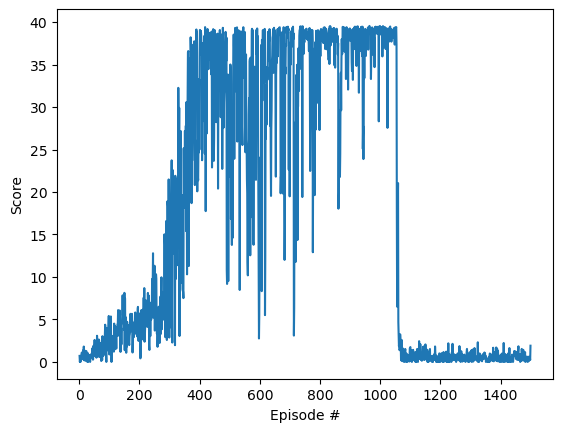

In [141]:
def ppo(n_episodes=1500, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
     
    max_score = -np.Inf
    first=False
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            actions, distributions,log_probs = agent.act(states)#choose an action 
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards_ = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done
            agent.step(states, actions, rewards_, next_states,
                       dones, distributions, log_probs)#collect events
            
            states = next_states
            score += np.mean(rewards_)
            
            if np.any(dones):
                break 
        
        agent.learn(next_states, GAMMA)
        
        mean_score_paral = score.mean()
        scores_deque.append(mean_score_paral)
        scores.append(mean_score_paral)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tLossActor: {:.8f} \tLossCritic : {:.8f}'.format(i_episode,
                                                                                                                   np.mean(scores_deque),
                                                                                                                   mean_score_paral,
                                                                                                                   np.mean(agent.actor_loss_history),
                                                                                                                   np.mean(agent.critic_loss_history)), end="")
        
        print(agent.actor_local.get_params(torch.FloatTensor(states).to(device)))
        agent.memory.clear_memory()
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_ppo_20agent.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_ppo_20agent.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>30:
            if first==True:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, '.format(
                    i_episode-100, 
                    np.mean(scores_deque)))
                torch.save(agent.actor_local.state_dict(), 'model_actor_ppo_20agent.pth')
                torch.save(agent.critic_local.state_dict(), 'model_critic_ppo_20agent.pth')
                first=True
                #break
    return scores

scores = ppo()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Tracking the variance of the actor distribution helps to adjust hyperparameters (especially the entropy coeficient loss). We want to penalize a low variance but having maximum of variance can stop the learning. <br>
So I decided to decrease my hyperparameter "entropy_coef" from 0.01 to 0.001<br>
I also decided to reduce the LAMBDA hyperparameter to reduce the Variance from Generalized Advantage Estimation (GAE) 


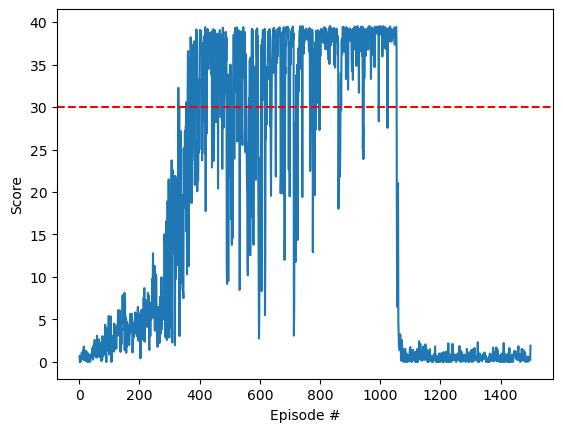

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.axhline(y=30, color='r', linestyle='--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()